#### 現場で使える機械学習 講座課題 - Car Fuel Consumption

- 問題設定 : 100kmあたりのガソリン消費量(consume)を予測

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import r2_score

# セルの表示行数を500行に拡張する
#pd.set_option("display.max_rows", 500)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

#### 1. [Day1] データの読み込み

##### 1.1. [Day1] 入力ファイルとなるCSVのデータ
|カラム名|内容|変数の種別|
|---|---|---|
|distance|走行距離(Km)|量的変数|
|consume|100kmあたりのガソリン消費量(L/100km)|量的変数|
|speed|平均速度(km/h)|量的変数|
|temp_inside|車内の気温(${}^\circ$C)|量的変数|
|temp_outside|外気温(${}^\circ$C)|量的変数|
|specials|特記事項 : 雨(rain/half rain half sun)，雪(snow)，エアコンの使用(AC)，出発時に車体が温かく感じるほどの晴れ(sun)|質的変数|
|gas_type|使用ガソリンの種別 : SP98("Super plus")，E10("super" gas with 10% Alcohol)|質的変数|
|AC|エアコン使用の有無(0:False, 1:True)|質的変数|
|rain|雨もしくは雪(0:False, 1:True)|質的変数|
|sun|出発時に車体が温かく感じるほどの晴れ(0:False, 1:True)|質的変数|
|refill liters|給油時のガソリン量(L)|量的変数|
|refill gas|給油時のガソリンの種別 : SP98("Super plus")，E10("super" gas with 10% Alcohol)|質的変数|

##### 1.2. [Day1] データの内容に対する考察
* 質的変数(specials)とダミー変数(AC, rain, sun)の関係が成り立つため specials は取り込まない
* rainとsunは「それ以外の天気」をカラムとして加えればone-hotエンコーディングの関係が成り立つ
* refill gas については、欠損値を補間した場合、データが gas_type と全件同一となるため取り込まない
* 問題設定より説明変数として使用することがないと判断し refill liters は取り込まない
* 質的変数(SP98, E10)はダミー変数(0, 1)に変換する方が特徴量を解析しやすい

In [3]:
# 提供者コメントのとおりデータの小数点記号がドイツ等で利用されるカンマであるため，read_csv時にdecimalオプションで小数点として認識させる
# replaceを使用して質的変数(SP98, E10)はダミー変数(1, 0)に変換する
df_consume = pd.read_csv("../1_data/measurements.csv", decimal=",")[['distance', 'consume', 'speed',
                                                                     'temp_inside', 'temp_outside',
                                                                     'gas_type', 'AC', 'rain', 'sun']].replace({'SP98': 0, 'E10': 1})

# 取り込んだデータの欠損値の有無を確認
df_consume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     376 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null int64
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
dtypes: float64(3), int64(6)
memory usage: 27.4 KB


#### 2. [Day1] データに対する前処理
* 欠損値の補間
* メモリ使用量低減のための型変換

In [4]:
# 上記infoにて判明したtemp_insideの欠損値を欠損の直前値で補間する
df_consume['temp_inside'] = df_consume['temp_inside'].fillna(method = 'ffill')

# メモリ使用量低減のために0と1しか使用しない質的変数のカラム属性をint8に変換する
df_consume['gas_type'] = df_consume['gas_type'].astype(np.int8)
df_consume['AC'] = df_consume['AC'].astype(np.int8)
df_consume['rain'] = df_consume['rain'].astype(np.int8)
df_consume['sun'] = df_consume['sun'].astype(np.int8)

# 欠損値補間とデータ型変更が適用されたことを確認
df_consume.info()

# 取り込んだデータを見る
display(df_consume.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null int8
AC              388 non-null int8
rain            388 non-null int8
sun             388 non-null int8
dtypes: float64(3), int64(2), int8(4)
memory usage: 16.8 KB


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,1,0,0,0
1,12.0,4.2,30,21.5,13,1,0,0,0
2,11.2,5.5,38,21.5,15,1,0,0,0
3,12.9,3.9,36,21.5,14,1,0,0,0
4,18.5,4.5,46,21.5,15,1,0,0,0


#### 3. [Day1] データの特徴を分析する
##### 3.1. [Day1] 要約統計量の出力

In [5]:
# 要約統計量を出力する 
df_consume.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,388.0,19.652835,22.667837,1.3,11.80,14.6,19.0,216.1
consume,388.0,4.912371,1.033172,3.3,4.30,4.7,5.3,12.2
speed,388.0,41.927835,13.598524,14.0,32.75,40.5,50.0,90.0
temp_inside,388.0,21.890464,1.035038,19.0,21.50,22.0,22.5,25.5
temp_outside,388.0,11.358247,6.991542,-5.0,7.00,10.0,16.0,31.0
gas_type,388.0,0.412371,0.492897,0.0,0.00,0.0,1.0,1.0
AC,388.0,0.077320,0.267443,0.0,0.00,0.0,0.0,1.0
rain,388.0,0.123711,0.329677,0.0,0.00,0.0,0.0,1.0
sun,388.0,0.082474,0.275441,0.0,0.00,0.0,0.0,1.0


##### 3.2. [Day1] 密度図の出力
* 質的変数(gas_type, AC, rain, sun)と量的変数consumeとの間に相関関係があるのかを密度図で確認する
* 質的変数と量的変数の相関関係は相関比を算出すれば定量的に判断可能であるが、相関比算出関数の実装まで至らなかった<br>
　⇒DAY2提出時の課題としたい

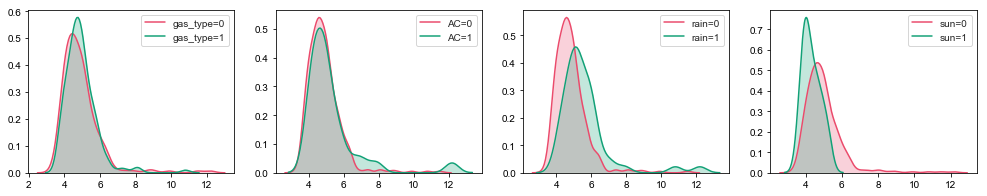

In [6]:
# warning出力時にjupyterがインストールされているフォルダが見えてしまうので抑制する
import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=Warning)

# 質的変数(gas_type, AC, rain, sun)とconsumeとの間に相関関係があるのかを密度図で見る
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
sns.set_style("whitegrid", {'axes.grid': True})

sns.kdeplot(df_consume[df_consume['gas_type'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[0], label='gas_type=0');
sns.kdeplot(df_consume[df_consume['gas_type'] == 1].consume, shade=True, color='#12a177', ax=axes[0], label='gas_type=1');
sns.kdeplot(df_consume[df_consume['AC'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[1], label='AC=0');
sns.kdeplot(df_consume[df_consume['AC'] == 1].consume, shade=True, color='#12a177', ax=axes[1], label='AC=1');
sns.kdeplot(df_consume[df_consume['rain'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[2], label='rain=0');
sns.kdeplot(df_consume[df_consume['rain'] == 1].consume, shade=True, color='#12a177', ax=axes[2], label='rain=1');
sns.kdeplot(df_consume[df_consume['sun'] == 0].consume, shade=True, color='#eb4b6c', ax=axes[3], label='sun=0');
sns.kdeplot(df_consume[df_consume['sun'] == 1].consume, shade=True, color='#12a177', ax=axes[3], label='sun=1');

###### 3.2.1. [Day1] 密度図に対する考察
* 赤と緑の密度図のズレが大きいほどconsumeとの間に相関関係がある(consumeの値の変化に作用する)と考えられる<br>
  よって
* rainとconsumeの間には弱い相関関係がある<br>
  rain=1の場合、天気が雨/雪のため水の抵抗がある(A) → 晴れや曇りの日より燃費が悪くなる(B)という「A→Bの因果関係がある」と考察される
* sunとconsumeの間には弱い相関関係がある<br>
  sun=1の場合、直射日光により車体が温かくなる(A) → 燃費が良くなる(B)という「A→Bの因果関係がある」と考察される

##### 3.3. [Day1] 散布図の出力
* 量的変数同士の相関関係を散布図にて確認する
* rainの値によって散布図の内容を色分けする

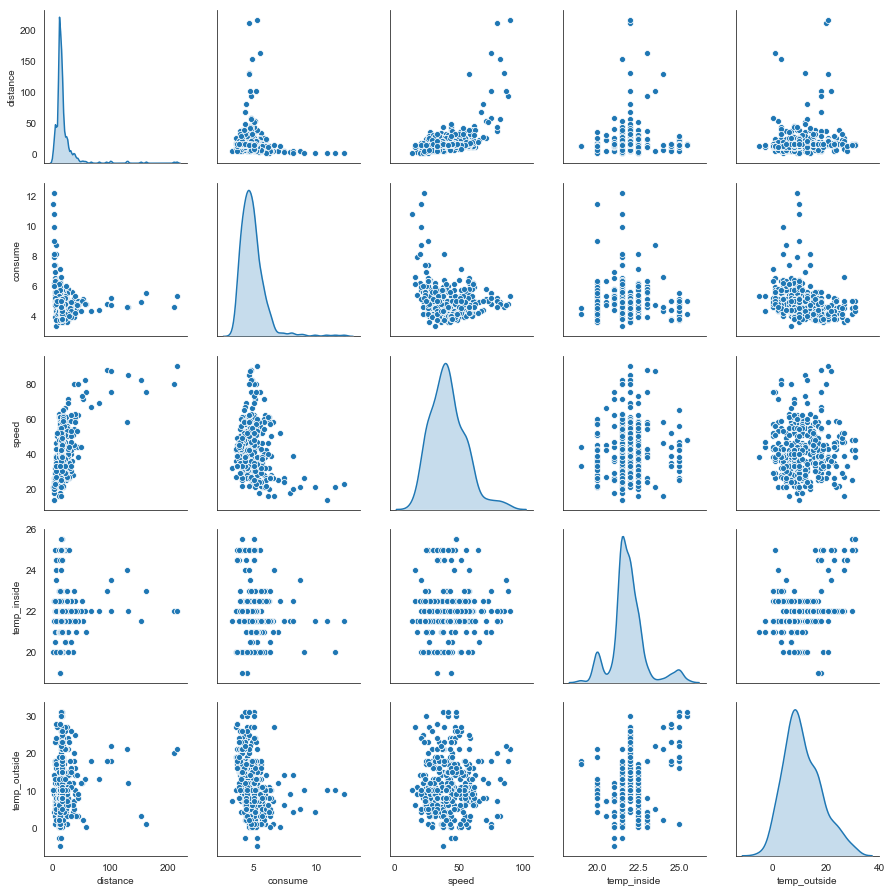

In [7]:
sns.set_style("white", {'axes.grid': False})

df_quantitative = df_consume.drop(['gas_type', 'AC', 'rain', 'sun'], axis=1)

# 量的変数を対象として散布図行列を作成する
# 散布図行列の対角成分を密度図としている
sns.pairplot(df_quantitative, vars=['distance', 'consume', 'speed', 'temp_inside', 'temp_outside'], palette='husl', diag_kind='kde');

###### 3.3.1. [Day1] 散布図に対する考察
* 目的変数consumeと他の量的変数との間それぞれにて外れ値をある程度整理すれば弱い相関関係があるように見える
* temp_outsideがconsumeに対して線形に近い分布に見える
* 客観的な特徴選択が可能ではなかったので相関係数の算出にて判断したい

##### 3.4. [Day1] ヒートマップの出力
* 相関係数の値をヒートマップにて着色し確認する
* 質的変数と量的変数の相関関係について定量的に判断するために今回は相関比を使用せず相関係数にて代替する

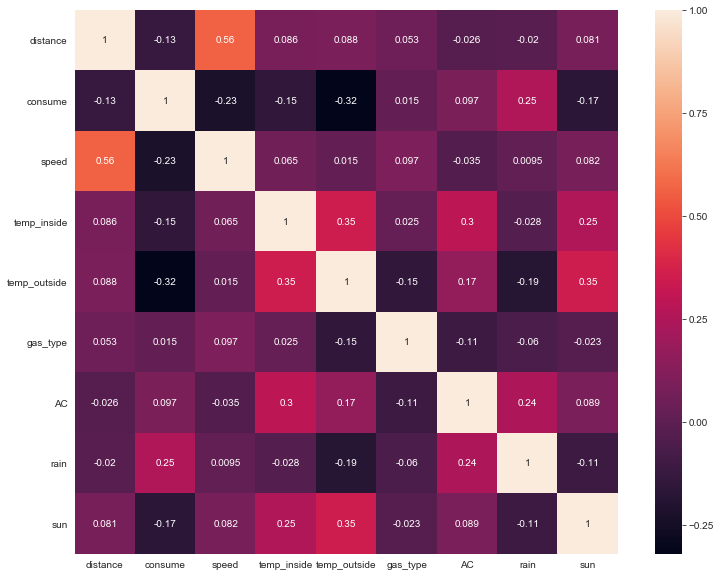

In [8]:
plt.figure(figsize=(13, 10))
# 相関係数をヒートマップにして可視化
sns.heatmap(df_consume.corr(), annot=True, square=True);

###### 3.4.1. [Day1] ヒートマップに対する考察
* 相関係数 r の値と相関の強さの関係として一般的に使用されるものは以下である

|相関係数|相関の強さ|
|---|---|
|0.7 ≤ &#124; r &#124;|強い相関あり|
|0.4 ≤ &#124; r &#124; < 0.7|中程度の相関あり|
|0.2 ≤ &#124; r &#124; < 0.4|弱い相関あり|
|&#124; r &#124; < 0.2|ほとんど相関なし|

よって目的変数consumeとの相関係数の絶対値 |r|が0.2以上となる以下の項目を説明変数とする (|r|の高い順)
* temp_outside (r=-0.32)　⇒　consumeと負の相関関係がある (外気温が高いとconsumeが低い = 燃費が良い)
* rain (r=0.25)　⇒　consumeと正の相関関係がある (雨/雪が降るとconsumeが高い = 燃費が悪い)
* speed (r=-0.23)　⇒　consumeと負の相関関係がある (平均時速が高いとconsumeが低い = 燃費が良い)

#### 4. [Day1] 回帰分析を実行し精度評価指標値を取得する
* 線形回帰を実行する
* MSE, MAE, RMSEを取得し,RMSE/MAEの値も最終的な判断のために算出する<br>
　⇒講師日熊様より前記判断基準は誤りであるとの指摘有り

In [9]:
#warnings.filterwarnings('default')
df_mean_error_day1 = pd.DataFrame(columns=["説明変数", "MSE","MAE","RMSE", "RMSE / MAE"], index=[])

# 四捨五入した数値を返す関数
def r(data, precision):
    return np.round(data, decimals=precision)

def mean_errors(str, y, y_pred):
    global df_mean_error_day1
    mse = mean_squared_error(y, y_pred)  # MSEを計算
    mae = mean_absolute_error(y, y_pred) # MAEを計算
    rmse = np.sqrt(mse)                  # RMSEを計算

    # pandas.Seriesに誤差数値を設定
    sr_mean_error = pd.Series(data=[str, r(mse,4), r(mae,4), r(rmse,4), r(rmse/mae,4)], index=df_mean_error_day1.columns)

    df_mean_error_day1 = df_mean_error_day1.append(sr_mean_error, ignore_index=True)

##### 4.1. [Day1] 回帰分析の実行と精度評価指標値の取得　その1
* temp_outsite, rain, speedを説明変数として線形回帰を実行する

In [10]:
# 説明変数をtemp_outside, rain, speedとする。

# 係数を求める
y = df_consume["consume"].to_numpy()
X = df_consume[["temp_outside", "rain", "speed"]].to_numpy()
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
display(regr.coef_)

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["rain"]
x3 = df_consume["speed"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, w3, squared_error))

# 値を予測

y_pred = regr.predict(X)

mean_errors('"temp_outside", "rain", "speed"', y, y_pred)

r2_score(y, y_pred)

array([-0.04144264,  0.62052816, -0.01712692])

w0 = 6.024, w1 = -0.041, w2 = 0.621, w3 = -0.017, 二乗誤差 = 167.2097


0.19046483826955973

##### 4.2. [Day1] 回帰分析の実行と精度評価指標値の取得　その2
* temp_outsite, rainを説明変数として線形回帰を実行する

In [11]:
# 説明変数をtemp_outside, rainとする。

# 係数を求める
y = df_consume["consume"].to_numpy()
X = df_consume[["temp_outside", "rain"]].to_numpy()
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["rain"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, squared_error))

# 値を予測
y_pred = regr.predict(X)

mean_errors('"temp_outside", "rain"', y, y_pred)

r2_score(y, y_pred)

w0 = 5.314, w1 = -0.042, w2 = 0.611, 二乗誤差 = 177.7016


0.13966932621504902

##### 4.3. [Day1] 回帰分析の実行と精度評価指標値の取得　その3
* temp_outsite, speedを説明変数として線形回帰を実行する

In [12]:
# 説明変数をtemp_outside, speedとする。

# 係数を求める
y = df_consume["consume"].to_numpy()
X = df_consume[["temp_outside", "speed"]].to_numpy()
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]

# 変数の設定
x1 = df_consume["temp_outside"]
x2 = df_consume["speed"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, squared_error))

# 値を予測
y_pred = regr.predict(X)

mean_errors('"temp_outside", "speed"', y, y_pred)

r2_score(y, y_pred)

w0 = 6.155, w1 = -0.047, w2 = -0.017, 二乗誤差 = 175.0255


0.1526255327309749

##### 4.4. [Day1] 回帰分析の実行と精度評価指標値の取得　その4
* temp_outsiteを説明変数として線形回帰を実行する

In [13]:
# 説明変数をtemp_outsideとする。

# 係数を求める
y = df_consume["consume"].to_numpy()
X = df_consume[["temp_outside"]].to_numpy()
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]

# 変数の設定
x1 = df_consume["temp_outside"]
y = df_consume["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, squared_error))

# 値を予測
y_pred = regr.predict(X)

mean_errors("temp_outside", y, y_pred)

r2_score(y, y_pred)

w0 = 5.451, w1 = -0.047, 二乗誤差 = 185.2923


0.1029194334666449

#### 5. [Day1] 精度評価指標値を表示する

In [14]:
display(df_mean_error_day1)

,説明変数,MSE,MAE,RMSE,RMSE / MAE
0,"""temp_outside"", ""rain"", ""speed""",0.8619,0.6188,0.9284,1.5002
1,"""temp_outside"", ""rain""",0.9160,0.6109,0.9571,1.5666
2,"""temp_outside"", ""speed""",0.9022,0.6332,0.9498,1.5001
3,temp_outside,0.9551,0.6271,0.9773,1.5585


#### 5.1. [Day1] 精度評価指標値を評価する
* RMSE/MAEの値が1.253に一番近い値(誤差が正規分布に従う)を精度の高い特徴選択とする
* 結論として，RMSE/MAEの値が1.5001となったtemp_outside, speedが説明変数の回帰モデルが一番精度の高い予測値となると考察される<br><br>
⇒講師日熊様より上記考察は標準化してから測定する値であり誤りであること、またMAEの値で評価するようにコメントあり
* よってMAEが一番低かったtemp_outside, rainが説明変数の回帰モデルが一番精度の高い予測値となると考察される

#### 6. [Day2] 異常値を観測し除外の有無を考察する
* 外れ値を含む箱ひげ図を表示する
* 箱ひげ図の第一四分位数と第三四分位数より外側の外れ値を実際に見て考察したい

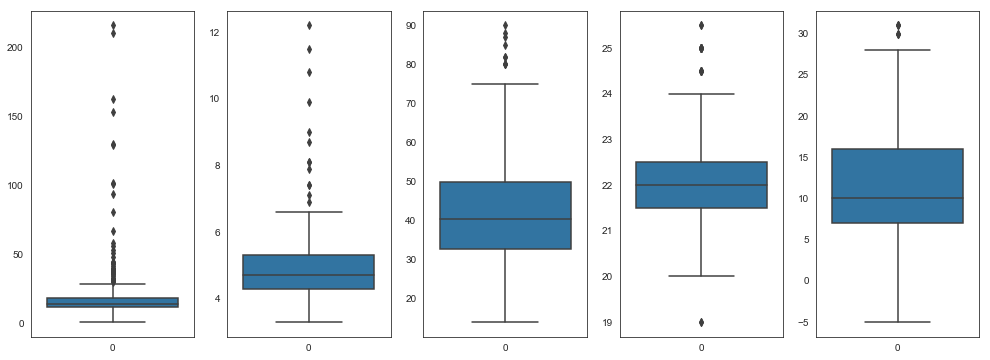

In [15]:
#ax = sns.boxplot(x=df_consume["distance"], y = df_consume["consume"])
fig, axes = plt.subplots(1, 5, figsize=(17,6))
sns.set_style("whitegrid", {'axes.grid': True})

sns.boxplot(data = df_consume["distance"], ax=axes[0]);
sns.boxplot(data = df_consume["consume"], ax=axes[1]);
sns.boxplot(data = df_consume["speed"], ax=axes[2]);
sns.boxplot(data = df_consume["temp_inside"], ax=axes[3]);
sns.boxplot(data = df_consume["temp_outside"], ax=axes[4]);

##### 6.1. [Day2] 異常値に対する考察　その1
* distanceとconsumeに関して極端に高い値の外れ値が存在するため実際の外れ値を見て判断したい
* その他の外れ値についても問題はないと考察した

In [16]:
# 上記極端に高い値の外れ値データを見る
display(df_consume.sort_values('distance', ascending=False).head(10))
display(df_consume.sort_values('consume', ascending=False).head(10))

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
319,216.1,5.3,90,22.0,21,0,0,0,1
318,211.0,4.6,80,22.0,20,0,0,0,0
106,162.7,5.5,75,23.0,1,0,0,0,0
55,153.5,4.9,82,21.5,3,0,0,1,0
189,130.3,4.6,85,22.0,12,1,0,0,0
334,129.7,4.6,58,24.0,21,1,0,0,0
272,101.9,5.2,75,22.0,18,1,0,0,0
333,100.9,4.7,87,23.5,22,1,0,0,0
273,93.9,4.8,88,23.0,18,1,1,0,1
188,81.2,4.4,69,22.0,13,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
61,2.1,12.2,23,21.5,9,0,1,1,0
210,1.3,11.5,21,20.0,10,0,0,0,0
147,1.7,10.8,14,21.5,10,1,0,1,0
45,2.0,9.9,21,21.5,4,0,0,0,0
206,2.4,9.0,26,20.0,10,0,0,0,0
112,5.1,8.7,21,23.5,5,0,0,0,0
254,2.0,8.1,20,22.5,14,1,0,0,0
160,5.1,8.1,39,21.5,4,1,0,0,0
60,2.9,7.9,18,21.5,9,0,1,1,0
37,4.9,7.4,26,21.5,6,1,0,0,0


##### 6.2. [Day2] 異常値に対する考察　その2
* distanceは走行距離であることから今回の外れ値について長距離走行に関するデータと判断し問題ないと考察した
* consumeの外れ値は100km走行に換算した場合のガソリン消費量であることから問題ないと考察した<br>
　⇒同一の走行距離でも坂道発進や頻繁なアイドリングで燃費が悪くなるケースが考えられるため

#### 7. [Day2] 量的変数を標準化する
* 3.3.の散布図行列の対角行列に表示されている密度図にて、全ての量的変数に一峰性があることを確認できたので、量的変数を標準化する

In [17]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
# 標準化する
df_consume_scaled_temp = pd.DataFrame(stdsc.fit_transform(df_quantitative), columns=df_quantitative.columns)
#df_consume_scaled = df_consume_scaled_temp.assign(gas_type=df_consume['gas_type'], AC=df_consume['AC'], rain=df_consume['rain'], sun=df_consume['sun'])
df_consume_scaled = pd.concat([df_consume_scaled_temp, df_consume['gas_type'], df_consume['AC'], df_consume['rain'], df_consume['sun']], axis=1)
del df_consume_scaled_temp

# 量的変数が標準化されたことを確認
display(df_consume_scaled.head())

# 要約統計量を出力し標準化されていること(平均=0, 標準偏差=1)であることを確認
df_consume_scaled.describe().T

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,0.368714,0.084925,-1.172804,-0.377733,0.091908,1,0,0,0
1,-0.338044,-0.690390,-0.878274,-0.377733,0.235123,1,0,0,0
2,-0.373381,0.569497,-0.289216,-0.377733,0.521552,1,0,0,0
3,-0.298288,-0.981133,-0.436480,-0.377733,0.378338,1,0,0,0
4,-0.050923,-0.399647,0.299843,-0.377733,0.521552,1,0,0,0


,count,mean,std,min,25%,50%,75%,max
distance,388.0,1.322682e-16,1.001291,-0.810687,-0.346878,-0.223195,-0.028837,8.677529
consume,388.0,-5.077553e-16,1.001291,-1.562618,-0.593475,-0.205818,0.375668,7.062756
speed,388.0,2.392130e-16,1.001291,-2.056392,-0.675786,-0.105135,0.594372,3.539666
temp_inside,388.0,-2.337191e-15,1.001291,-2.796221,-0.377733,0.105965,0.589662,3.491848
temp_outside,388.0,4.475229e-16,1.001291,-2.342740,-0.624165,-0.194521,0.664767,2.812986
gas_type,388.0,4.123711e-01,0.492897,0.000000,0.000000,0.000000,1.000000,1.000000
AC,388.0,7.731959e-02,0.267443,0.000000,0.000000,0.000000,0.000000,1.000000
rain,388.0,1.237113e-01,0.329677,0.000000,0.000000,0.000000,0.000000,1.000000
sun,388.0,8.247423e-02,0.275441,0.000000,0.000000,0.000000,0.000000,1.000000


##### 7.1. [Day2] 回帰分析の実行と精度評価指標値の取得　その1
* 標準化した量的変数を用いてtemp_outsite, rainを説明変数として線形回帰を実行する

In [18]:
#warnings.filterwarnings('default')
df_mean_error_day2 = pd.DataFrame(columns=["検証手法", "MAE"], index=[])

def mean_errors_day2(str, y, y_pred):
    global df_mean_error_day2
    mae = mean_absolute_error(y, y_pred) # MAEを計算

    # pandas.Seriesに誤差数値を設定
    sr_mean_error = pd.Series(data=[str, r(mae,4)], index=df_mean_error_day2.columns)

    df_mean_error_day2 = df_mean_error_day2.append(sr_mean_error, ignore_index=True)

w0 = -0.073, w1 = -0.284, w2 = 0.593, 二乗誤差 = 166.9042


0.1396693262150489

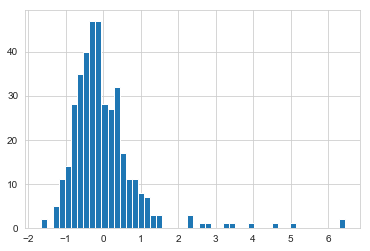

In [19]:
# 説明変数をtemp_outside, rainとする。

# 係数を求める
y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]

# 変数の設定
x1 = df_consume_scaled["temp_outside"]
x2 = df_consume_scaled["rain"]
y = df_consume_scaled["consume"]

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, 二乗誤差 = {:.4f}'
      .format(w0, w1, w2, squared_error))

# 値を予測
y_pred = regr.predict(X)

mean_errors_day2("標準化", y, y_pred)

# 線形回帰の残差(実在値と予測値の差)を表示する
pd.Series(y - y_pred).hist(bins=50);

r2_score(y, y_pred)

##### 8. [Day2] 交差検証法の実行と精度評価指標値の取得
* 交差検証法を使用してtemp_outsite, rainを説明変数とした線形回帰を実行する

Fold 1
MAE = 0.699

Fold 2
MAE = 0.667

Fold 3
MAE = 0.606

Fold 4
MAE = 0.537

Fold 5
MAE = 0.486

Cross Validation MAE = 0.599


-0.3135963597830518

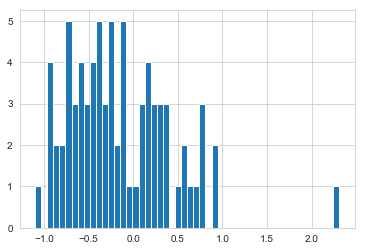

In [20]:
from sklearn.model_selection import KFold # 交差検証法に関する関数

y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()

#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

sr_mean_error = pd.Series(data=["(標準化+)交差検証", r(final_mae,4)], index=df_mean_error_day2.columns)
df_mean_error_day2 = df_mean_error_day2.append(sr_mean_error, ignore_index=True)
    
# 線形回帰の残差(実在値と予測値の差)を表示する
pd.Series(y_test - y_pred_test).hist(bins=50);

r2_score(y_test, y_pred_test)

##### 9. [Day2] リッジ回帰の実行と精度評価指標値の取得
* temp_outsite, rainを説明変数としたリッジ回帰を実行する
* 交差検証(RidgeCV)を使用してalpha(数式ではλ)パラメータのチューニングを実施する

平均誤差の最小値:  1.0
RidgeCVクラスによる最善値:  1.0


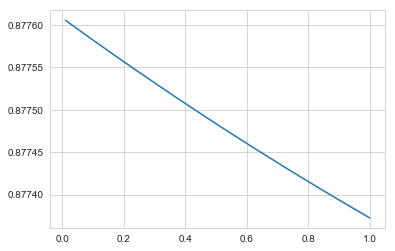

In [21]:
from sklearn.linear_model import RidgeCV

y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()

# 0.01から1の間のデータ点(合計50個: np.linspaceのnumのデフォルトが50)にてアルファをテストする
alphas_to_test = np.linspace(0.01, 1)
# store_cv_values=TrueでRidgeCVオブジェクトに交差検証の値を格納する
rcv = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
# 回帰を適合
rcv.fit(X, y)

# 平均誤差の最小値を特定し、その値をアルファとして選択
smallest_idx = rcv.cv_values_.mean(axis=0).argmin()
print("平均誤差の最小値: ", alphas_to_test[smallest_idx])

# RidgeCVクラスのrcvインスタンスによって特定された最善の値（上記平均誤差の最小値と一致する）
print("RidgeCVクラスによる最善値: ", rcv.alpha_)

# 50個のアルファの平均値をプロット
plt.plot(alphas_to_test, rcv.cv_values_.mean(axis=0));

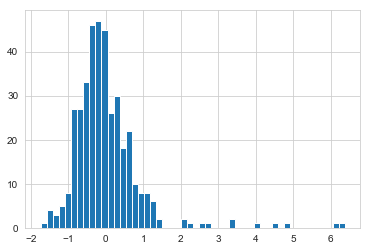

In [22]:
from sklearn.linear_model import Ridge #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()

degree = 9
alphas = [rcv.alpha_] # 上記RidgeCVにて求めたalpha(数式ではλ)の値を指定する
for alpha in zip(alphas):
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X, y)

    y_pred = est.predict(X)

    # 線形回帰の残差(実在値と予測値の差)を表示する
    pd.Series(y - y_pred).hist(bins=50);

mean_errors_day2("(標準化+)Ridge", y, y_pred)

##### 10. [Day2] ラッソ回帰の実行と精度評価指標値の取得
* temp_outsite, rainを説明変数としたラッソ回帰を実行する
* 交差検証(LassoCV)を使用してalpha(数式ではλ)パラメータのチューニングを実施する

In [23]:
from sklearn.linear_model import LassoCV

y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()

lassocv = LassoCV()
lassocv.fit(X, y)

print("LassoCVによる最適なラムダ: ", lassocv.alpha_)

LassoCVによる最適なラムダ:  0.0003208105881460973


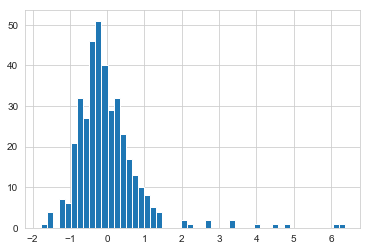

In [24]:
from sklearn.linear_model import Lasso, ElasticNet #正則化項付き最小二乗法を行うためのライブラリ

y = df_consume_scaled["consume"].to_numpy()
X = df_consume_scaled[["temp_outside", "rain"]].to_numpy()

degree = 9
alphas = [lassocv.alpha_] # 上記LassoCVにて求めたalpha(数式ではλ)の値を指定する
for alpha in zip(alphas):
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X, y)

    y_pred = est.predict(X)

    # 線形回帰の残差(実在値と予測値の差)を表示する
    pd.Series(y - y_pred).hist(bins=50);

mean_errors_day2("(標準化+)LASSO", y, y_pred)

#### 11. [Day2] 精度評価指標値を表示する
* Day1とDay2のMAEを比較する
* Day2の説明変数はDay1で一番MAEが低かったtemp_outside,rainで固定している

In [25]:
display(df_mean_error_day1)
display(df_mean_error_day2)

,説明変数,MSE,MAE,RMSE,RMSE / MAE
0,"""temp_outside"", ""rain"", ""speed""",0.8619,0.6188,0.9284,1.5002
1,"""temp_outside"", ""rain""",0.9160,0.6109,0.9571,1.5666
2,"""temp_outside"", ""speed""",0.9022,0.6332,0.9498,1.5001
3,temp_outside,0.9551,0.6271,0.9773,1.5585


,検証手法,MAE
0,標準化,0.5921
1,(標準化+)交差検証,0.5992
2,(標準化+)Ridge,0.5757
3,(標準化+)LASSO,0.5785


#### 11.1. [Day2] 精度評価指標値を評価する
* MAEの値が一番低いRidge回帰が検証手法として一番精度が高いと考察される

#### 12. [Day3] ステップワイズ法による特徴選択

In [26]:
#warnings.filterwarnings('default')
df_mean_error_day3 = pd.DataFrame(columns=["検証手法", "MAE"], index=[])

def mean_errors_day3(str, y, y_pred):
    global df_mean_error_day3
    mae = mean_absolute_error(y, y_pred) # MAEを計算

    # pandas.Seriesに誤差数値を設定
    sr_mean_error = pd.Series(data=[str, r(mae,4)], index=df_mean_error_day3.columns)

    df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)

In [27]:
from sklearn.feature_selection import RFECV

# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=True)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [28]:
train_label = df_consume["consume"]
train_data = df_consume.drop("consume", axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [29]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[3 2 1 1 1 1 1 1]


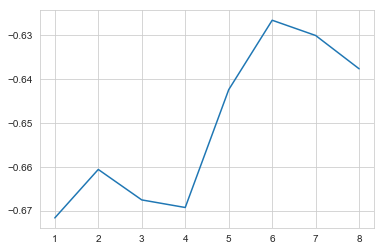

In [30]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [31]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([False, False,  True,  True,  True,  True,  True,  True])

In [32]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([ True,  True, False, False, False, False, False, False])

In [33]:
# 削除してもよい特徴の名前を取得する
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['distance', 'speed'], dtype='object')

In [34]:
# drop関数で特徴を削除
selected_train_data = train_data.drop(remove_feature, axis=1)
selected_train_data.head()

,temp_inside,temp_outside,gas_type,AC,rain,sun
0,21.5,12,1,0,0,0
1,21.5,13,1,0,0,0
2,21.5,15,1,0,0,0
3,21.5,14,1,0,0,0
4,21.5,15,1,0,0,0


Fold 1
MAE = 0.723

Fold 2
MAE = 0.727

Fold 3
MAE = 0.63

Fold 4
MAE = 0.586

Fold 5
MAE = 0.505

Cross Validation MAE = 0.634


-0.3269632059367442

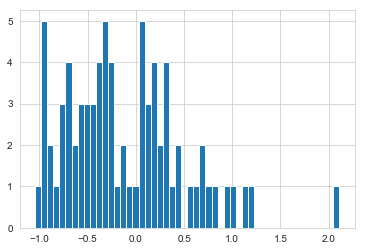

In [35]:
# 交差検証法を実施
y = df_consume["consume"].to_numpy()
X = selected_train_data.to_numpy()

#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True, normalize=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

sr_mean_error = pd.Series(data=["ステップワイズ法", r(final_mae,4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)
    
# 線形回帰の残差(実在値と予測値の差)を表示する
pd.Series(y_test - y_pred_test).hist(bins=50);

r2_score(y_test, y_pred_test)

#### 13. [Day3] LASSOによる特徴選択

In [36]:
from sklearn.feature_selection import SelectFromModel

# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [37]:
train_label = df_consume["consume"]
train_data = df_consume.drop("consume", axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [38]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False,  True,  True,  True, False,  True,  True,  True])

In [39]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['distance', 'gas_type'], dtype='object')

In [40]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.        , 0.01391808, 0.02581017, 0.03709777, 0.        ,
       0.26470984, 0.46116224, 0.05547963])

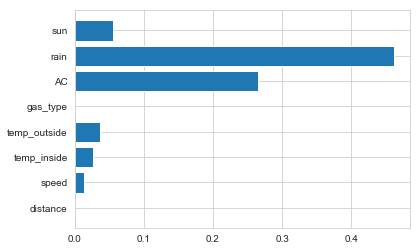

,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,26,21.5,12,1,0,0,0
1,12.0,30,21.5,13,1,0,0,0
2,11.2,38,21.5,15,1,0,0,0
3,12.9,36,21.5,14,1,0,0,0
4,18.5,46,21.5,15,1,0,0,0


In [41]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()
train_data.head()

Fold 1
MAE = 0.706

Fold 2
MAE = 0.708

Fold 3
MAE = 0.629

Fold 4
MAE = 0.582

Fold 5
MAE = 0.536

Cross Validation MAE = 0.632


-0.4217776789205343

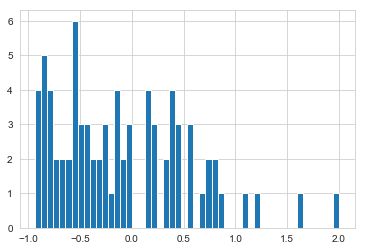

In [42]:
# 交差検証法を実施
y = df_consume["consume"].to_numpy()
#X = train_data.drop(train_data.columns[removed_idx]).to_numpy()
X = train_data.drop(train_data.columns[removed_idx], axis=1).to_numpy()

#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True, normalize=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

sr_mean_error = pd.Series(data=["LASSO(特徴選択あり)", r(final_mae,4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)
    
# 線形回帰の残差(実在値と予測値の差)を表示する
pd.Series(y_test - y_pred_test).hist(bins=50);

r2_score(y_test, y_pred_test)

#### 14. [Day3] Kerasによる回帰分析

In [43]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

Using TensorFlow backend.


In [44]:
# 説明変数はステップワイズ法にて導き出された temp_inside,temp_outside, gas_type, AC, rain, sun を使用する
y = df_consume["consume"].to_numpy()
X = train_data.drop(train_data.columns[removed_idx], axis=1).to_numpy()

# 回帰分析NNモデルの作成
def reg_model():
    model = Sequential()
    model.add(Dense(10, input_dim=6, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    # compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

# show the model summary
reg_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 263
Trainable params: 263
Non-trainable params: 0
_________________________________________________________________


In [45]:
# データを分割する（テストデータ10%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

estimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

sr_mean_error = pd.Series(data=["Keras NNによる回帰分析", r(mean_absolute_error(y_test, y_pred),4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)

Instructions for updating:
Use tf.cast instead.


In [46]:
'''
# KFoldを利用した交差検証によるモデルの実行
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)

# show its root mean square error
results = cross_val_score(estimator, X, y, scoring='neg_mean_absolute_error', cv=kfold)
mae = -results.mean()

sr_mean_error = pd.Series(data=["Keras+KFold+CVによる回帰分析", r(mae,4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)
'''

'\n# KFoldを利用した交差検証によるモデルの実行\nseed = 7\nnp.random.seed(seed)\nestimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=10, verbose=0)\nkfold = KFold(n_splits=10, random_state=seed)\n\n# show its root mean square error\nresults = cross_val_score(estimator, X, y, scoring=\'neg_mean_absolute_error\', cv=kfold)\nmae = -results.mean()\n\nsr_mean_error = pd.Series(data=["Keras+KFold+CVによる回帰分析", r(mae,4)], index=df_mean_error_day3.columns)\ndf_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)\n'

In [47]:
# ディープラーニングによる回帰分析の作成
def deep_reg_model():
    model = Sequential()
    model.add(Dense(10, input_dim=6, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

# show the model summary
deep_reg_model().summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2816      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
___________________________

In [48]:
# データ分割モデルの実行
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
estimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

sr_mean_error = pd.Series(data=["Keras DL+データ分割による回帰分析", r(mean_absolute_error(y_test, y_pred),4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)

'''
# KFoldを利用した交差検証モデルの実行
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)

# show its root mean square error
results = cross_val_score(estimator, X, y, scoring='neg_mean_absolute_error', cv=kfold)
mae = -results.mean()

sr_mean_error = pd.Series(data=["Keras DL+KFold+CVによる回帰分析", r(mae,4)], index=df_mean_error_day3.columns)
df_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)
'''

'\n# KFoldを利用した交差検証モデルの実行\nseed = 7\nnp.random.seed(seed)\nestimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=10, verbose=0)\nkfold = KFold(n_splits=10, random_state=seed)\n\n# show its root mean square error\nresults = cross_val_score(estimator, X, y, scoring=\'neg_mean_absolute_error\', cv=kfold)\nmae = -results.mean()\n\nsr_mean_error = pd.Series(data=["Keras DL+KFold+CVによる回帰分析", r(mae,4)], index=df_mean_error_day3.columns)\ndf_mean_error_day3 = df_mean_error_day3.append(sr_mean_error, ignore_index=True)\n'

#### 15. [Day3] 精度評価指標値を表示する

    Day1とDay2とDay3のMAEを比較する
    Day2の説明変数はDay1で一番MAEが低かったtemp_outside,rainで固定している
    Day3のKerasの説明変数はステップワイズ法にて導き出された temp_inside,temp_outside, gas_type, AC, rain, sun を使用している

In [49]:
display(df_mean_error_day1)
display(df_mean_error_day2)
display(df_mean_error_day3)

,説明変数,MSE,MAE,RMSE,RMSE / MAE
0,"""temp_outside"", ""rain"", ""speed""",0.8619,0.6188,0.9284,1.5002
1,"""temp_outside"", ""rain""",0.9160,0.6109,0.9571,1.5666
2,"""temp_outside"", ""speed""",0.9022,0.6332,0.9498,1.5001
3,temp_outside,0.9551,0.6271,0.9773,1.5585


,検証手法,MAE
0,標準化,0.5921
1,(標準化+)交差検証,0.5992
2,(標準化+)Ridge,0.5757
3,(標準化+)LASSO,0.5785


,検証手法,MAE
0,ステップワイズ法,0.6343
1,LASSO(特徴選択あり),0.6322
2,Keras NNによる回帰分析,0.5526
3,Keras DL+データ分割による回帰分析,0.4440


##### 15.1. [Day3] 精度評価指標値を考察する

    一番MAEの性能値が低いステップワイズ法で導き出された説明変数を利用しても上位の性能値を出すNN、DLの回帰分析能力の高さは流石
    
※特記事項<br>
    KerasでKFoldを使うと処理が終わらなかったので原因を究明する必要がある